In [6]:
import pandas as pd
import numpy as np
import yfinance as yf
from pandas_datareader import data as pdr
import seaborn as sns
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import *
from statsmodels.tsa.stattools import coint
import random
import csv
import os

In [3]:
# We use General Motors and Ford for this example.
x_ticker = "GM"
y_ticker = "F"

In [15]:
x = np.array(pd.read_csv("./Data/{}.csv".format(x_ticker))['Close'])
y = np.array(pd.read_csv("./Data/{}.csv".format(y_ticker))['Close'])

In [16]:
score, pvalue, _ = coint(x, y, maxlag=1)

In [17]:
pvalue

0.09448643058639161

In [18]:
from sklearn.linear_model import LinearRegression

In [22]:
x = x.reshape((-1, 1))
y = y.reshape((-1, 1))

In [24]:
model = LinearRegression()
model.fit(x, y)

LinearRegression()

In [27]:
print(model.coef_, model.intercept_)
pred = model.predict(x)

[[1.1125958]] [-1.48723068]


In [28]:
df = pd.DataFrame(pred, columns = ["pred"])
df2 = pd.DataFrame(y, columns = ["actual"])
df3 = pd.DataFrame(x, columns = ["base"])
d = pd.concat([df, df2, df3], axis = 1)

<AxesSubplot:>

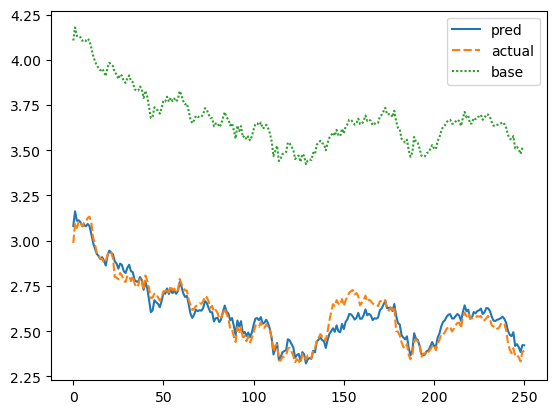

In [29]:
sns.lineplot(data = d)

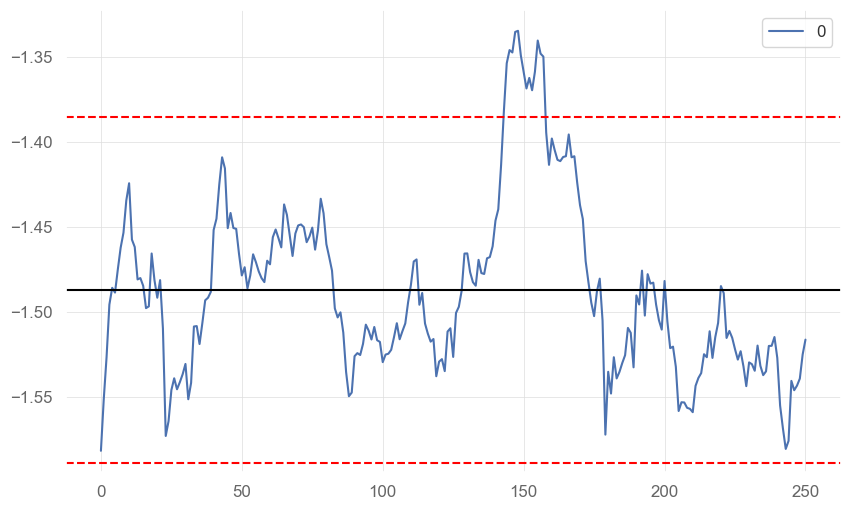

In [43]:
spread_df = pd.DataFrame(y - model.coef_ * x)
spread = y - model.coef_ * x
spread_df.plot()
plt.axhline(spread.mean(), color = "black")
std = spread.std()
plt.axhline(spread.mean() + 1.96 * std, color = "red", linestyle='--')
plt.axhline(spread.mean() - 1.96 * std, color = "red", linestyle='--')

When spread is low, y - x is low, so x is priced high, and y is priced low. Coefficient denotes hedge.
Buy 1 stock of y, and sell coeff stock of x. Then, The mean reverts, so y - coeff x is likely to rise.


In [41]:
import webbrowser as web
import quantstats as qs
import datetime as dt
from dateutil.relativedelta import relativedelta
import os

In [131]:
def pair_trading_strat(tickX, tickY, start, end, conf):
    t = yf.Ticker(tickX)
    data = pd.DataFrame()
    data['X'] = t.history(start = start, end = end)['Close']
    t = yf.Ticker(tickY)
    data['Y'] = t.history(start = start, end = end)['Close']
    logX = np.log(data['X'])
    logY = np.log(data['Y'])
    model = LinearRegression()
    model.fit(np.array(logX).reshape((-1, 1)), np.array(logY).reshape((-1, 1)))
    spread = np.array(logY) - model.coef_ * np.array(logX)
    data['logX'] = logX
    data['logY'] = logY
    data['returnX'] = logX.diff()
    data['returnY'] = logY.diff()
    spread = spread.reshape((-1,))
    data['spread'] = spread
    spread_np = np.array(spread)
    SPMean = spread_np.mean()
    SPstd = spread_np.std()
    # data['spread'].plot()
    data['strategyX'] = np.where(data['spread'] > SPMean + conf * SPstd, model.coef_, 0).reshape((-1,))
    data['strategyX'] = np.where(data['spread'] < SPMean - conf * SPstd, -model.coef_, data['strategyX']).reshape((-1,))
    data['strategyX'] = data['strategyX'].shift(1)
    data['strategyY'] = np.where(data['spread'] > SPMean + conf * SPstd, -1.0, 0).reshape((-1,))
    data['strategyY'] = np.where(data['spread'] < SPMean - conf * SPstd, 1, data['strategyY']).reshape((-1,))
    data['strategyY'] = data['strategyY'].shift(1) # time lag to consider that we don't buy the stock yesterday's closing price, but today's closing price.
    data['return'] = data['strategyX'] * data['returnX'] + data['strategyY'] * data['returnY']
    return data['return']
gm_f = pair_trading_strat("F", "GM", dt.datetime(2020, 1, 1), dt.datetime(2021, 12, 31), 1.96)


In [112]:
gm_f.index = gm_f.index.tz_localize(None)

<AxesSubplot:xlabel='Date'>

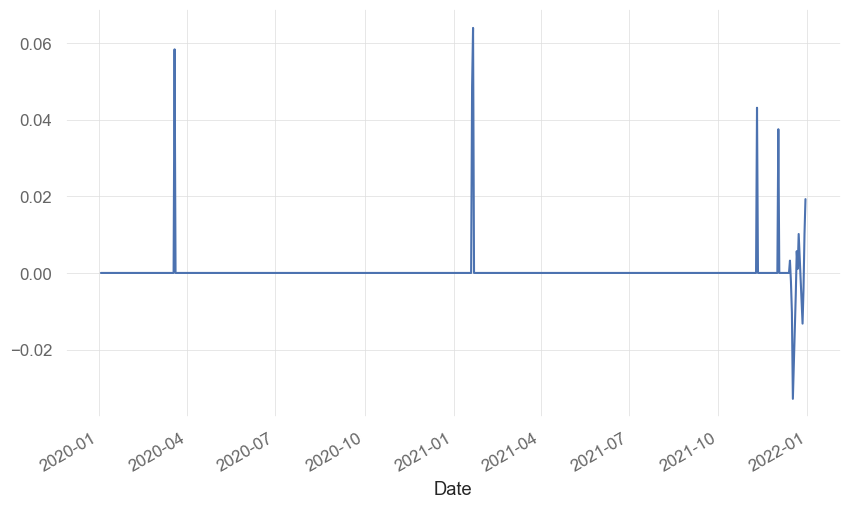

In [113]:
gm_f.plot()

In [109]:
qs.extend_pandas()

In [ ]:
qs.reports.html(gm_f, output="./output/gm_f.html", download_filename="./output/gm_f.html")

In [127]:
def pair_trading_strat_outsample(tickX, tickY, start, end, test_start, test_end, conf):
    t = yf.Ticker(tickX)
    data = pd.DataFrame()
    data['X'] = t.history(start = start, end = end)['Close']
    t = yf.Ticker(tickY)
    data['Y'] = t.history(start = start, end = end)['Close']
    logX = np.log(data['X'])
    logY = np.log(data['Y'])
    model = LinearRegression()
    model.fit(np.array(logX).reshape((-1, 1)), np.array(logY).reshape((-1, 1)))
    spread = np.array(logY) - model.coef_ * np.array(logX)
    data['logX'] = logX
    data['logY'] = logY
    data['returnX'] = logX.diff()
    data['returnY'] = logY.diff()
    spread = spread.reshape((-1,))
    data['spread'] = spread
    spread_np = np.array(spread)
    SPMean = spread_np.mean()
    SPstd = spread_np.std()
    # data['spread'].plot()
    # data['strategyX'] = np.where(data['spread'] > SPMean + 1.96 * SPstd, model.coef_, 0).reshape((-1,))
    # data['strategyX'] = np.where(data['spread'] < SPMean - 1.96 * SPstd, -model.coef_, data['strategyX']).reshape((-1,))
    # data['strategyX'] = data['strategyX'].shift(1)
    # data['strategyY'] = np.where(data['spread'] > SPMean + 1.96 * SPstd, -1.0, 0).reshape((-1,))
    # data['strategyY'] = np.where(data['spread'] < SPMean - 1.96 * SPstd, 1, data['strategyY']).reshape((-1,))
    # data['strategyY'] = data['strategyY'].shift(1) # time lag to consider that we don't buy the stock yesterday's closing price, but today's closing price.
    # data['return'] = data['strategyX'] * data['returnX'] + data['strategyY'] * data['returnY']
    t = yf.Ticker(tickX)
    test_data = pd.DataFrame()
    test_data['X'] = t.history(start = test_start, end = test_end)['Close']
    t = yf.Ticker(tickY)
    test_data['Y'] = t.history(start = test_start, end = test_end)['Close']
    test_logX = np.log(test_data['X'])
    test_logY = np.log(test_data['Y'])
    test_data['logX'] = test_logX
    test_data['logY'] = test_logY
    test_data['returnX'] = test_logX.diff()
    test_data['returnY'] = test_logY.diff()
    test_spread = np.array(test_logY) - model.coef_ * np.array(test_logX)
    test_spread = test_spread.reshape((-1,))
    test_data['spread'] = test_spread
    # test_data['spread'].plot()
    test_data['strategyX'] = np.where(test_data['spread'] > SPMean + conf * SPstd, model.coef_, 0).reshape((-1,))
    test_data['strategyX'] = np.where(test_data['spread'] < SPMean - conf * SPstd, -model.coef_, test_data['strategyX']).reshape((-1,))
    test_data['strategyX'] = test_data['strategyX'].shift(1)
    test_data['strategyY'] = np.where(test_data['spread'] > SPMean + conf * SPstd, -1.0, 0).reshape((-1,))
    test_data['strategyY'] = np.where(test_data['spread'] < SPMean - conf * SPstd, 1, test_data['strategyY']).reshape((-1,))
    test_data['strategyY'] = test_data['strategyY'].shift(1) # time lag to consider that we don't buy the stock yesterday's closing price, but today's closing price.
    test_data['return'] = test_data['strategyX'] * test_data['returnX'] + test_data['strategyY'] * test_data['returnY']
    return test_data['return']
gm_f_test = pair_trading_strat_outsample("F", "GM", dt.datetime(2020, 1, 1), dt.datetime(2021, 12, 31), dt.datetime(2022, 1, 1), dt.datetime(2022, 12, 31), 1.96)


<AxesSubplot:xlabel='Date'>

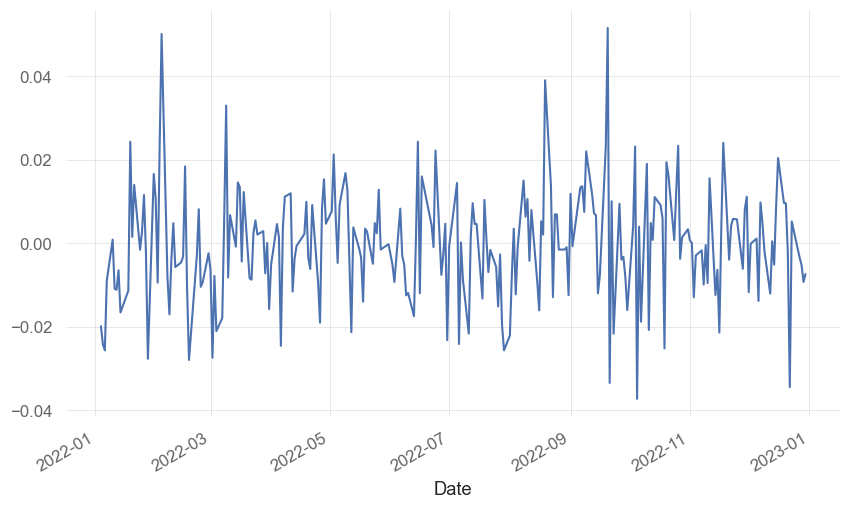

In [120]:
gm_f_test.plot()

In [123]:
gm_f_test.index = gm_f_test.index.tz_localize(None)

In [124]:
qs.reports.html(gm_f_test, output="./output/gm_f_test.html", download_filename="./output/gm_f_test.html")

Date
2022-01-03 00:00:00-05:00    NaN
2022-01-04 00:00:00-05:00    0.0
2022-01-05 00:00:00-05:00    0.0
2022-01-06 00:00:00-05:00    0.0
2022-01-07 00:00:00-05:00    0.0
                            ... 
2022-12-23 00:00:00-05:00    0.0
2022-12-27 00:00:00-05:00    0.0
2022-12-28 00:00:00-05:00    0.0
2022-12-29 00:00:00-05:00    0.0
2022-12-30 00:00:00-05:00    0.0
Name: strategyX, Length: 251, dtype: float64


C:\Users\18hli\AppData\Roaming\Python\Python37\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\18hli\AppData\Roaming\Python\Python37\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\18hli\AppData\Roaming\Python\Python37\site-packages\scipy\stats\_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0
C:\Users\18hli\AppData\Roaming\Python\Python37\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\18hli\AppData\Roaming\Python\Python37\site-packages\scipy\stats\_distn_infrastructure.py:2003: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\Users\18hli\AppData\Roaming\Python\Python37\site-packages\scipy\st

Date
2022-01-03    NaN
2022-01-04    0.0
2022-01-05   -0.0
2022-01-06    0.0
2022-01-07    0.0
             ... 
2022-12-23    0.0
2022-12-27    0.0
2022-12-28   -0.0
2022-12-29    0.0
2022-12-30   -0.0
Name: return, Length: 251, dtype: float64

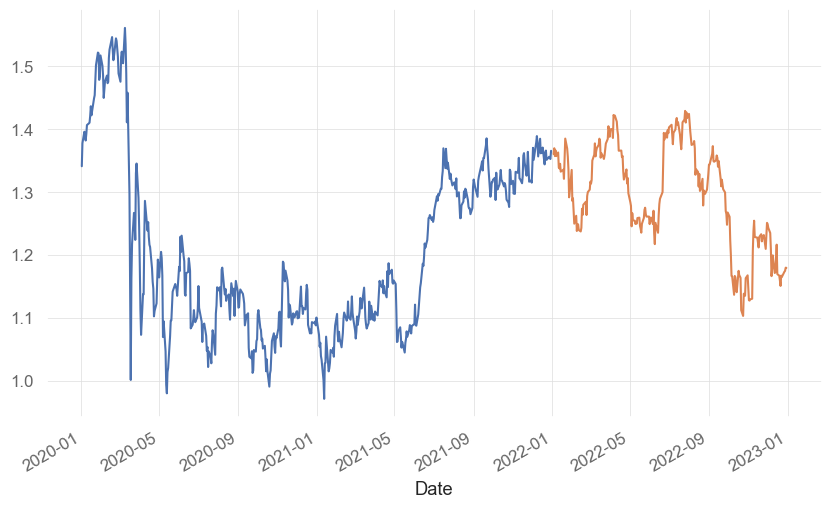

In [126]:
def generateReport(tickerA, tickerB, conf):
    ret = pair_trading_strat(tickerA, tickerB, dt.datetime(2020, 1, 1), dt.datetime(2021, 12, 31), conf)
    ret.index = ret.index.tz_localize(None)
    qs.reports.html(ret, output="./output/oracle/{}-{}.html".format(tickerA, tickerB), download_filename="./output/oracle/{}-{}.html".format(tickerA, tickerB))
    ret = pair_trading_strat_outsample(tickerA, tickerB, dt.datetime(2020, 1, 1), dt.datetime(2021, 12, 31), dt.datetime(2022, 1, 1), dt.datetime(2022, 12, 31), conf)
    ret.index = ret.index.tz_localize(None)
    qs.reports.html(ret, output="./output/test/{}-{}.html".format(tickerA, tickerB), download_filename="./output/test/{}-{}.html".format(tickerA, tickerB))
    return ret
generateReport("DOW","WELL", 1.96)